In [1]:
import platform
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.core.nanops import bottleneck_switch

from Detector_Classes.M3RefTracking import M3RefTracking
from Detector_Classes.DetectorConfigLoader import DetectorConfigLoader
from Detector_Classes.DreamDetector import DreamDetector

from det_classes_test import plot_ray_hits_2d, align_dream, get_residuals, get_efficiency, get_residuals_subdets_with_err, get_rays_in_sub_det_vectorized, get_rays_in_sub_det, get_raw_residuals, get_circle_scan, plot_2D_circle_scan

In [2]:
# Check if platform is Windows or Linux
if platform.system() == 'Windows':
    base_dir = 'F:/Saclay/cosmic_data/'
    det_type_info_dir = 'C:/Users/Dylan/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = 'F:/Saclay/Analysis/Cosmic Bench/11-5-24/'
    chunk_size = 100  # Number of files to process at once
elif platform.system() == 'Linux' and platform.node() == 'dylan-MS-7C84':
    base_dir = '/media/ucla/Saclay/cosmic_data/'
    det_type_info_dir = '/home/dylan/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = '/media/ucla/Saclay/Analysis/Cosmic Bench/11-5-24/'
    chunk_size = 100  # Number of files to process at once
elif platform.system() == 'Linux' and platform.node() == 'dphnpct50.extra.cea.fr':
    base_dir = '/local/home/dn277127/Bureau/cosmic_data/'
    det_type_info_dir = '/local/home/dn277127/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = '/local/home/dn277127/Bureau/cosmic_data/Analysis/11-15-24/'
    chunk_size = 0.5  # Number of files to process at once
else:
    raise OSError('Unknown platform')

run_name = 'rd542_plein_1_overnight_9-11-25'
run_dir = f'{base_dir}{run_name}/'
sub_run_name = 'night_test'

det_single = 'rd542_plein_1'

file_nums = list(range(0, 9))
# file_nums = list(range(0, 109))
# file_nums = 'all'

noise_sigma = 4

# realign_dream = True  # If False, read alignment from file, if True, realign Dream detector
realign_dream = False  # If False, read alignment from file, if True, realign Dream detector

run_json_path = f'{run_dir}run_config.json'
data_dir = f'{run_dir}{sub_run_name}/filtered_root/'
ped_dir = f'{run_dir}{sub_run_name}/decoded_root/'
m3_dir = f'{run_dir}{sub_run_name}/m3_tracking_root/'
alignment_dir = f'{run_dir}alignments/'

z_align_range = [5, 5]  # mm range to search for optimal z position
z_rot_align_range = [-2, 2]

try:
    os.mkdir(alignment_dir)
except FileExistsError:
    pass
try:
    os.mkdir(out_dir)
except FileExistsError:
    pass

In [3]:
print(f'Getting ray data...')
ray_data = M3RefTracking(m3_dir, single_track=True, file_nums=file_nums)
print(f'{len(ray_data.ray_data)} rays')

Getting ray data...


100%|██████████| 12/12 [00:00<00:00, 56.89it/s]

62298 rays


Getting no cut ray data...


100%|██████████| 12/12 [00:00<00:00, 40.37it/s]


233546 rays, fraction remaining: 26.67%


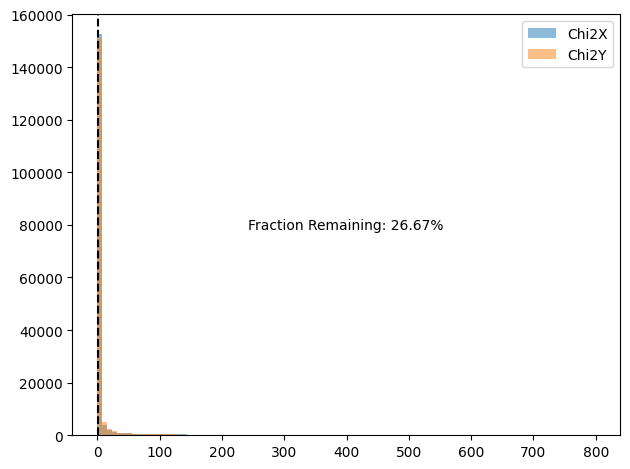

In [4]:
print(f'Getting no cut ray data...')
ray_data_no_cut = M3RefTracking(m3_dir, single_track=False, file_nums=file_nums)
fraction_remaining = len(ray_data.ray_data) / len(ray_data_no_cut.ray_data)
print(f'{len(ray_data_no_cut.ray_data)} rays, fraction remaining: {fraction_remaining * 100:.2f}%')

fig, ax = plt.subplots()
ax.hist(np.min(ray_data_no_cut.ray_data['Chi2X'], axis=1), bins=100, alpha=0.5, label='Chi2X')
ax.hist(np.min(ray_data_no_cut.ray_data['Chi2Y'], axis=1), bins=100, alpha=0.5, label='Chi2Y')
ax.axvline(ray_data_no_cut.chi2_cut, color='black', ls='--')
ax.annotate(f'Fraction Remaining: {fraction_remaining * 100:.2f}%', (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
ax.legend()
fig.tight_layout()

In [5]:
det_config_loader = DetectorConfigLoader(run_json_path, det_type_info_dir)

In [6]:
det_config = det_config_loader.get_det_config(det_single, sub_run_name=sub_run_name)
det = DreamDetector(config=det_config)
print(f'FEU Num: {det.feu_num}')
print(f'FEU Channels: {det.feu_connectors}')
print(f'HV: {det.hv}')
det.load_dream_data(data_dir, ped_dir, noise_sigma, file_nums, chunk_size, save_waveforms=False, waveform_fit_func='parabola_vectorized')
print(f'Hits shape: {det.dream_data.hits.shape}')

FEU Num: 6
FEU Channels: [1, 2, 3, 4]
HV: {'drift': 800, 'resist_1': 420, 'resist_2': 420}
Reading in data...
Getting sub chunk 1/2, events: 0-12975 of 25950


100%|██████████| 1/1 [00:05<00:00,  5.76s/it]


Read in data shape: (12975, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 25.92it/s]


Fitting time: 0.3019108772277832 s
Processed sub-chunk 1/2
Getting sub chunk 2/2, events: 12975-25950 of 25950


100%|██████████| 1/1 [00:05<00:00,  5.73s/it]


Read in data shape: (12975, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 26.31it/s]


Fitting time: 0.3500847816467285 s
Processed sub-chunk 2/2
Processed chunk 1/9
Getting sub chunk 1/2, events: 0-12974 of 25949


100%|██████████| 1/1 [00:05<00:00,  5.85s/it]


Read in data shape: (12974, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 24.71it/s]


Fitting time: 0.4030120372772217 s
Processed sub-chunk 1/2
Getting sub chunk 2/2, events: 12974-25949 of 25949


100%|██████████| 1/1 [00:05<00:00,  5.85s/it]


Read in data shape: (12975, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 22.66it/s]


Fitting time: 0.49189329147338867 s
Processed sub-chunk 2/2
Processed chunk 2/9
Getting sub chunk 1/2, events: 0-12975 of 25951


100%|██████████| 1/1 [00:06<00:00,  6.09s/it]


Read in data shape: (12975, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 20.37it/s]


Fitting time: 0.5820512771606445 s
Processed sub-chunk 1/2
Getting sub chunk 2/2, events: 12975-25951 of 25951


100%|██████████| 1/1 [00:06<00:00,  6.42s/it]


Read in data shape: (12976, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 22.25it/s]


Fitting time: 0.562443733215332 s
Processed sub-chunk 2/2
Processed chunk 3/9
Getting sub chunk 1/2, events: 0-12973 of 25947


100%|██████████| 1/1 [00:06<00:00,  6.24s/it]


Read in data shape: (12973, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 20.54it/s]


Fitting time: 0.6653218269348145 s
Processed sub-chunk 1/2
Getting sub chunk 2/2, events: 12973-25947 of 25947


100%|██████████| 1/1 [00:05<00:00,  5.90s/it]


Read in data shape: (12974, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 23.17it/s]


Fitting time: 0.624021053314209 s
Processed sub-chunk 2/2
Processed chunk 4/9
Getting sub chunk 1/2, events: 0-12975 of 25950


100%|██████████| 1/1 [00:06<00:00,  6.24s/it]


Read in data shape: (12975, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 22.85it/s]


Fitting time: 0.6547553539276123 s
Processed sub-chunk 1/2
Getting sub chunk 2/2, events: 12975-25950 of 25950


100%|██████████| 1/1 [00:06<00:00,  6.44s/it]


Read in data shape: (12975, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 22.60it/s]


Fitting time: 0.6962521076202393 s
Processed sub-chunk 2/2
Processed chunk 5/9
Getting sub chunk 1/2, events: 0-12974 of 25948


100%|██████████| 1/1 [00:06<00:00,  6.87s/it]


Read in data shape: (12974, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 22.61it/s]


Fitting time: 0.7346217632293701 s
Processed sub-chunk 1/2
Getting sub chunk 2/2, events: 12974-25948 of 25948


100%|██████████| 1/1 [00:07<00:00,  7.18s/it]


Read in data shape: (12974, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 20.77it/s]


Fitting time: 0.9133772850036621 s
Processed sub-chunk 2/2
Processed chunk 6/9
Getting sub chunk 1/2, events: 0-12974 of 25948


100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


Read in data shape: (12974, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 21.99it/s]


Fitting time: 0.8193700313568115 s
Processed sub-chunk 1/2
Getting sub chunk 2/2, events: 12974-25948 of 25948


100%|██████████| 1/1 [00:06<00:00,  6.80s/it]


Read in data shape: (12974, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


Fitting time: 0.8356492519378662 s
Processed sub-chunk 2/2
Processed chunk 7/9
Getting sub chunk 1/2, events: 0-12977 of 25955


100%|██████████| 1/1 [00:07<00:00,  7.54s/it]


Read in data shape: (12977, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 22.61it/s]


Fitting time: 0.8676719665527344 s
Processed sub-chunk 1/2
Getting sub chunk 2/2, events: 12977-25955 of 25955


100%|██████████| 1/1 [00:10<00:00, 10.65s/it]


Read in data shape: (12978, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 25.96it/s]


Fitting time: 0.8162305355072021 s
Processed sub-chunk 2/2
Processed chunk 8/9
Getting sub chunk 1/2, events: 0-12974 of 25948


100%|██████████| 1/1 [00:07<00:00,  7.04s/it]


Read in data shape: (12974, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 25.19it/s]


Fitting time: 0.8374695777893066 s
Processed sub-chunk 1/2
Getting sub chunk 2/2, events: 12974-25948 of 25948


100%|██████████| 1/1 [00:07<00:00,  7.93s/it]


Read in data shape: (12974, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:00<00:00, 21.95it/s]


Fitting time: 1.0048651695251465 s
Processed sub-chunk 2/2
Processed chunk 9/9
Getting hits...
Hits shape: (233546, 256)


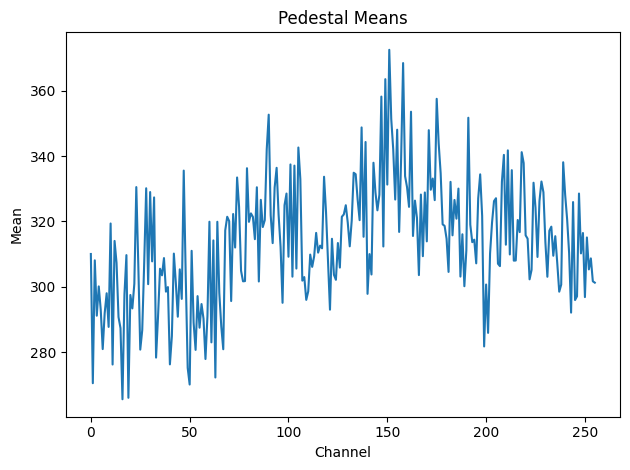

In [7]:
det.dream_data.plot_pedestals()

/local/home/dn277127/PycharmProjects/saclay_micromegas/Detector_Classes/DreamData.py:765: RuntimeWarning: All-NaN slice encountered
  event_max_amps = np.nanmax(self.data_amps, axis=1)


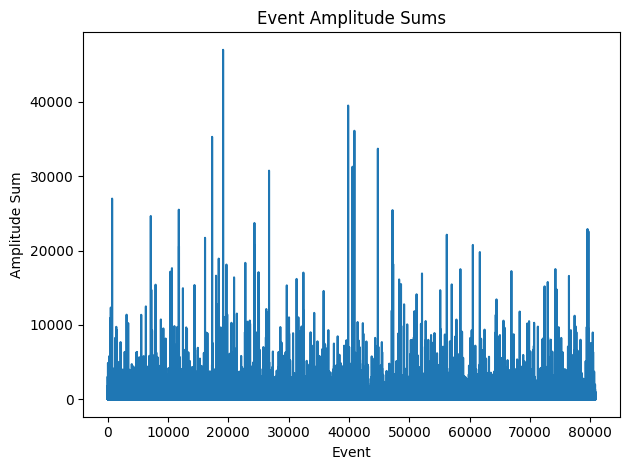

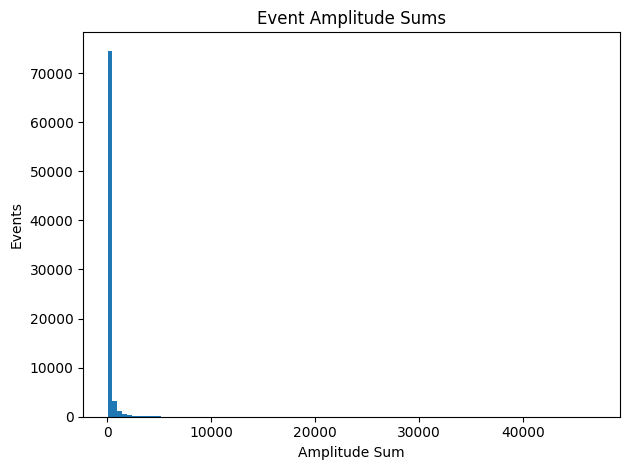

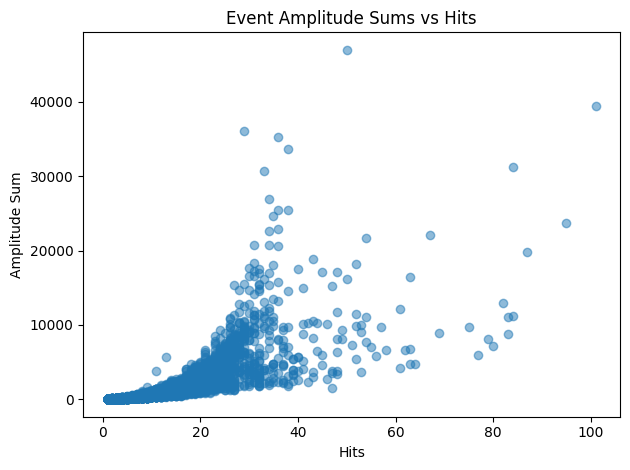

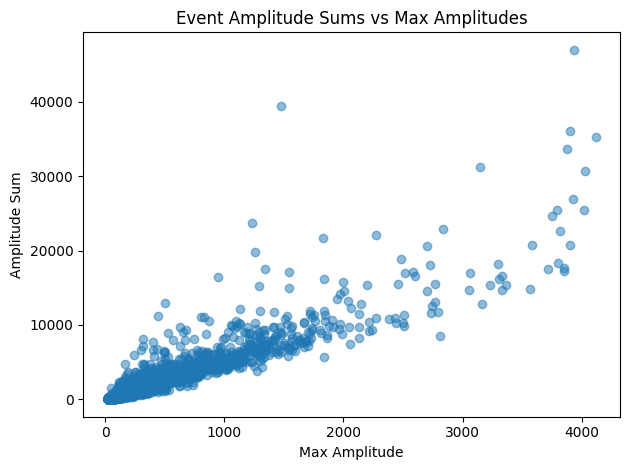

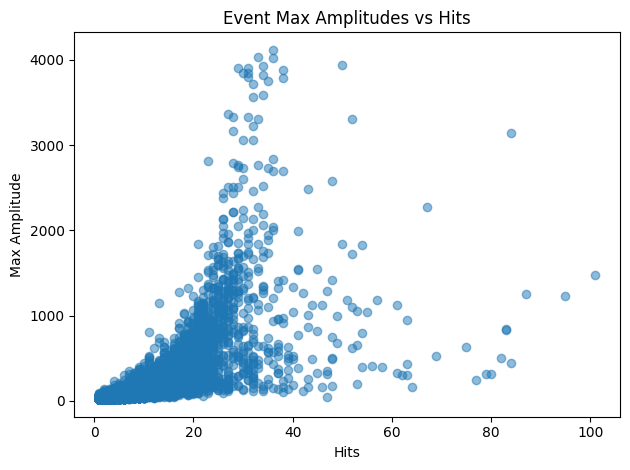

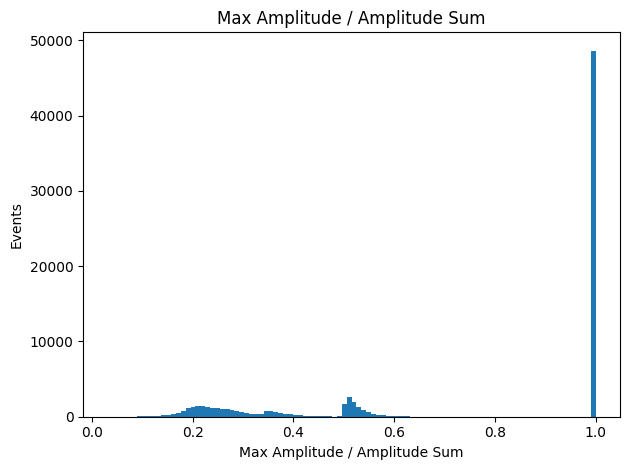

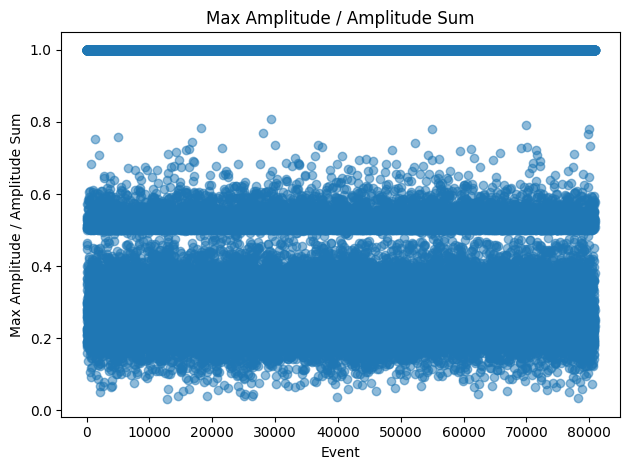

In [8]:
det.dream_data.plot_noise_metric()

Connector 1 Dead Strips: []
Connector 2 Dead Strips: []
Connector 3 Dead Strips: []
Connector 4 Dead Strips: []


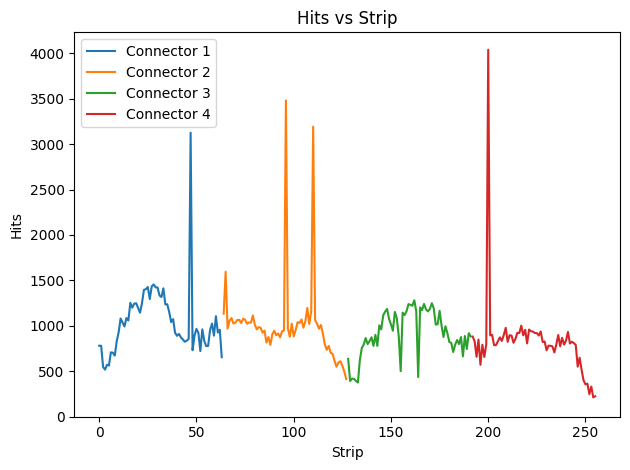

In [9]:
det.dream_data.plot_hits_vs_strip(print_dead_strips=True)

In [ ]:
det.dream_data.plot_raw_amps_2d_hist()

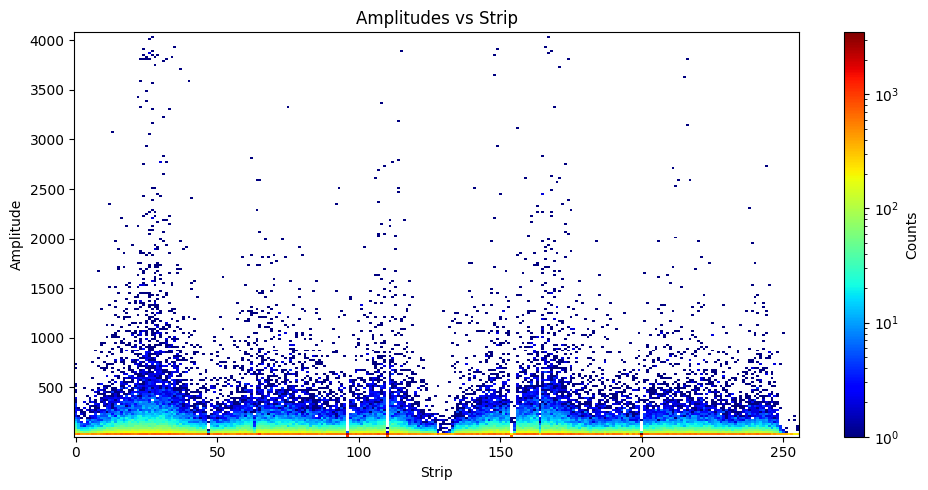

In [10]:
det.dream_data.plot_amplitudes_vs_strip()

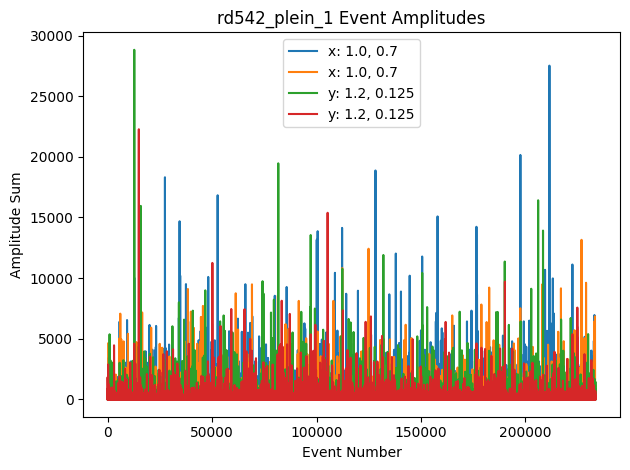

In [11]:
det.make_sub_detectors()
event_nums = det.plot_xy_amp_sum_vs_event_num(True, 500, False, 15)

if realign_dream:
    det.center[2] = 722
#     det.add_rotation(90, 'z')

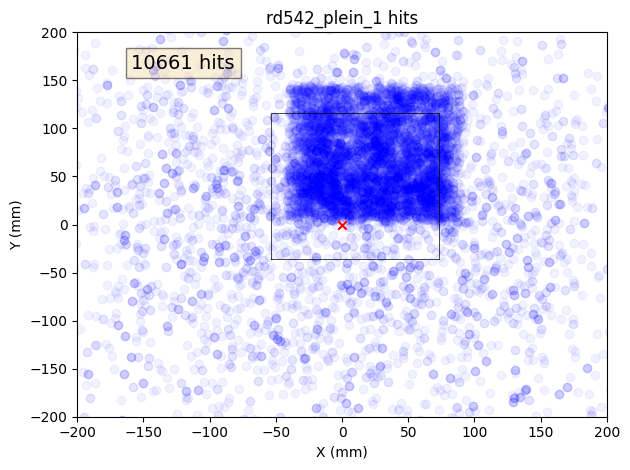

In [12]:
plot_ray_hits_2d(det, ray_data)

In [13]:
det.plot_hits_1d()

In [14]:
print(len(det.dream_data.hits))

233546


In [15]:
# for event_num in range(min(len(det.dream_data.hits), 2)):
#     det.plot_event_1d(event_num)
#     det.plot_event_2d(event_num)
#     det.dream_data.plot_waveforms(event_num)

In [16]:
z_orig = det.center[2]
x_bnds = det.center[0] - det.size[0] / 2, det.center[0] + det.size[0] / 2
y_bnds = det.center[1] - det.size[1] / 2, det.center[1] + det.size[1] / 2
ray_traversing_triggers = ray_data.get_traversing_triggers(z_orig, x_bnds, y_bnds, expansion_factor=0.1)

alignment_file = f'{alignment_dir}{det.name}_alignment.txt'
if realign_dream:
    align_dream(det, ray_data, z_align_range, z_rot_align_range)
    det.write_det_alignment_to_file(alignment_file)
else:
    det.read_det_alignment_from_file(alignment_file)

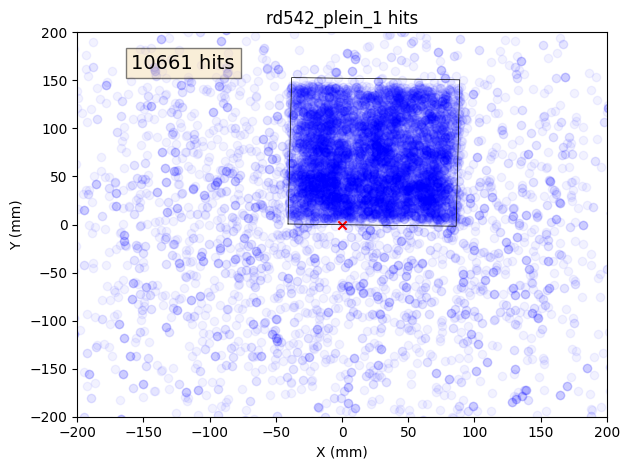

In [17]:
plot_ray_hits_2d(det, ray_data)

Pre-filtered rays: 62298
All rays: 14131


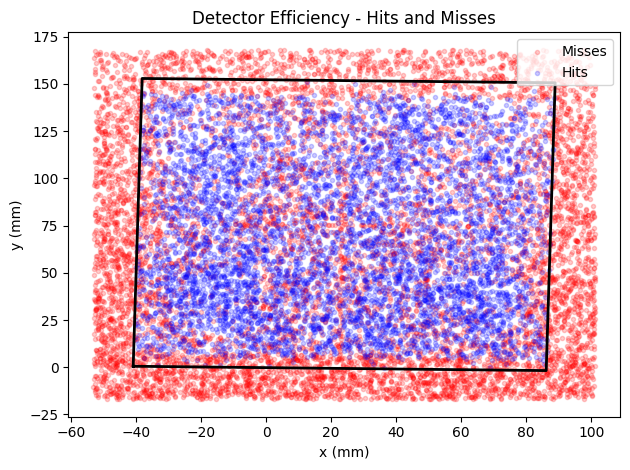

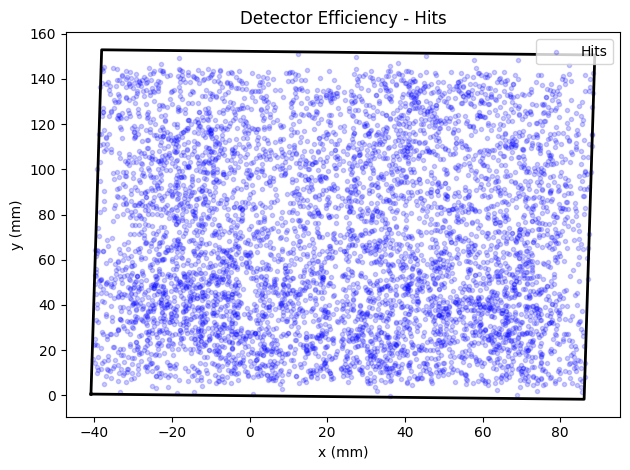

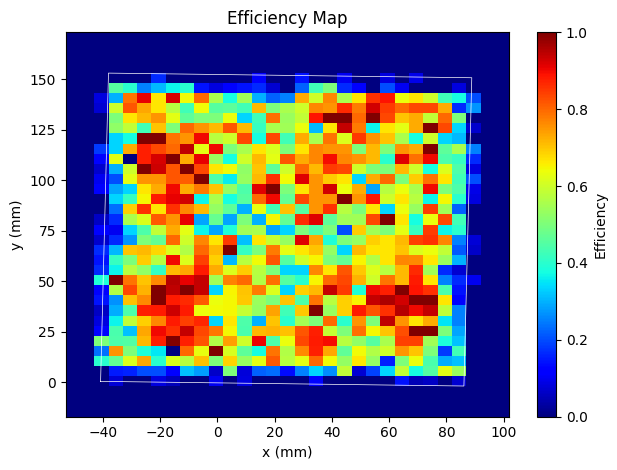

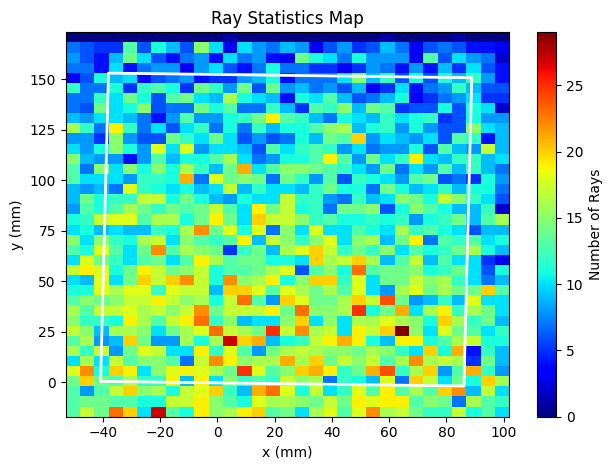

In [45]:
get_efficiency(det, ray_data, plot=True, in_det=True, tolerance=0.2, grid_size=5)

X Residuals: Mean=-21μm, Std=525μm
Y Residuals: Mean=6μm, Std=687μm
X Residuals: Mean=22μm, Std=557μm
Y Residuals: Mean=14μm, Std=614μm
X Residuals: Mean=-30μm, Std=577μm
Y Residuals: Mean=-52μm, Std=714μm
X Residuals: Mean=89μm, Std=590μm
Y Residuals: Mean=-36μm, Std=653μm


(np.float64(0.006764822518663566),
 np.float64(-0.021543661961888408),
 np.float64(0.49340070479986053),
 np.float64(0.6373993963957896))

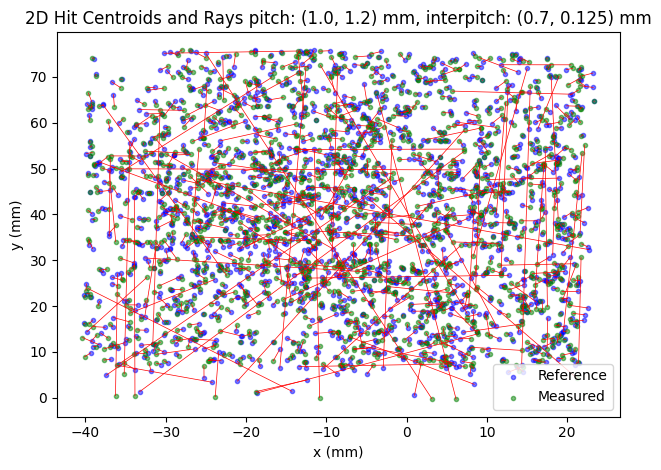

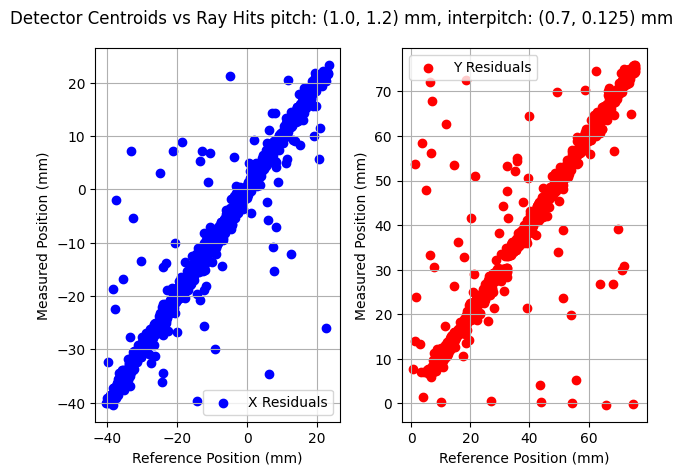

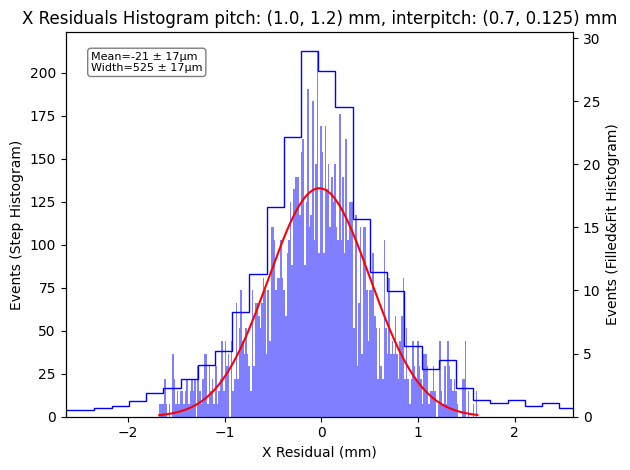

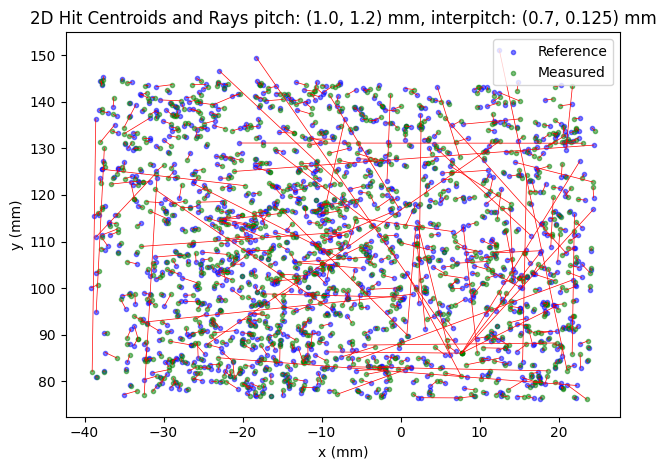

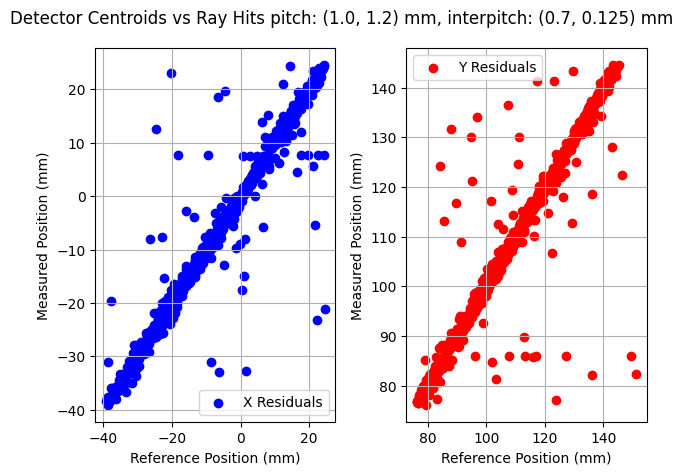

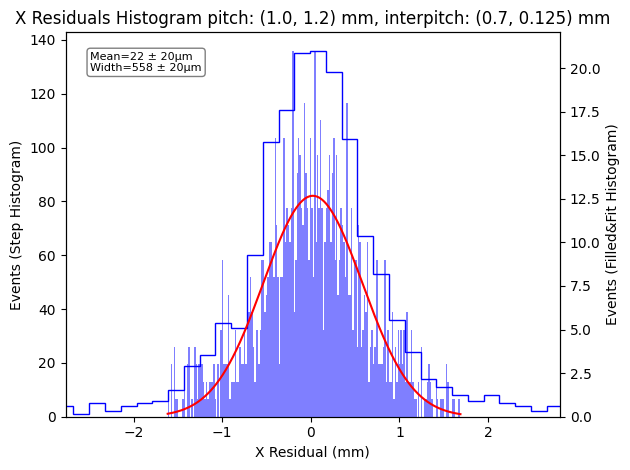

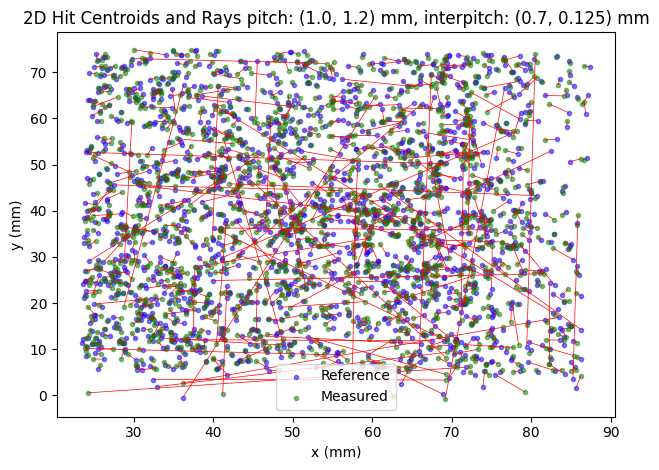

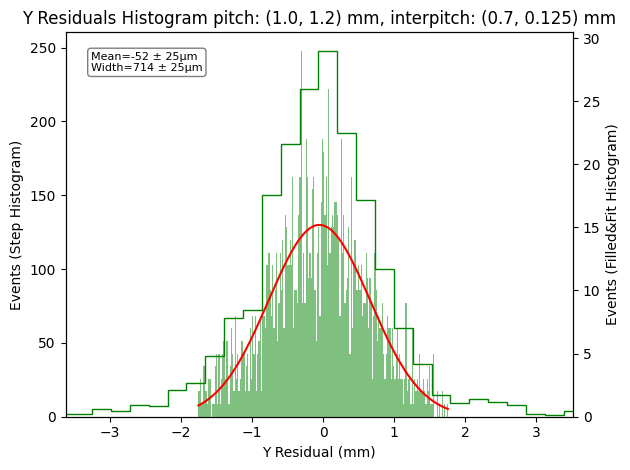

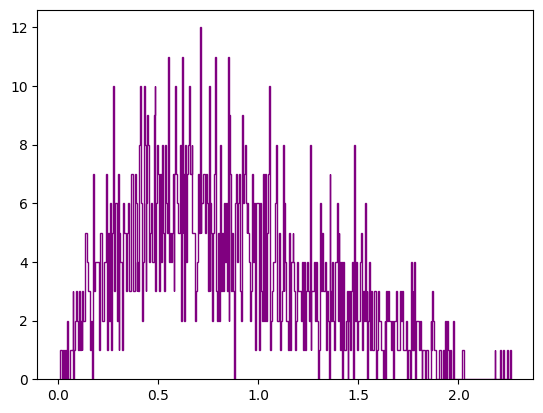

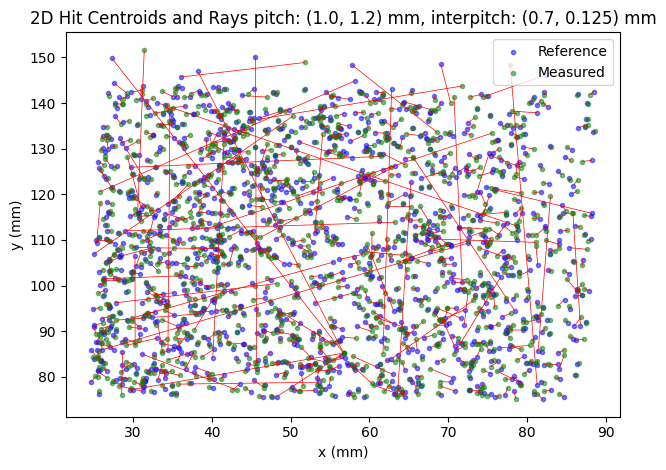

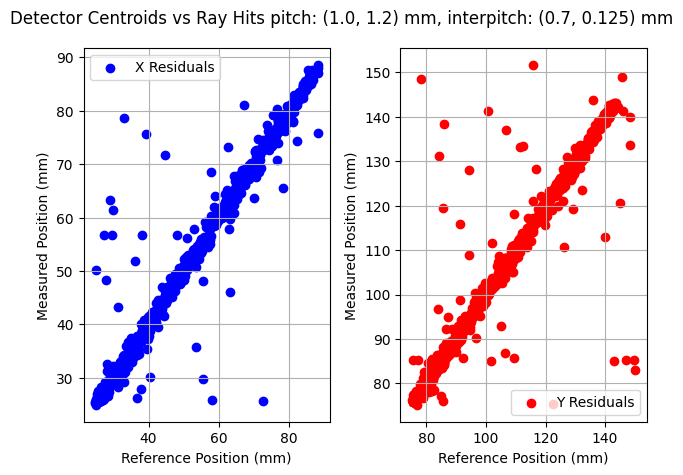

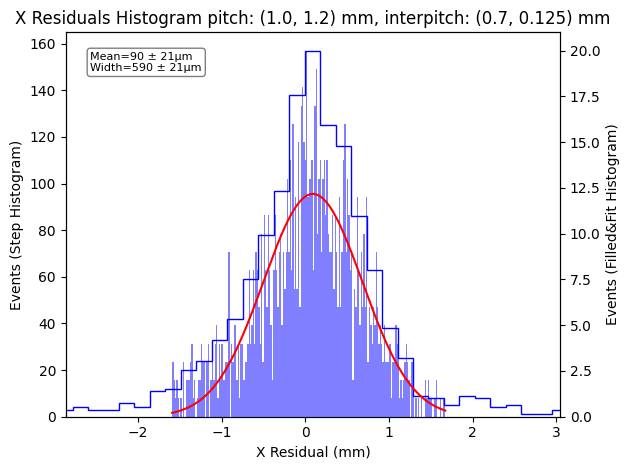

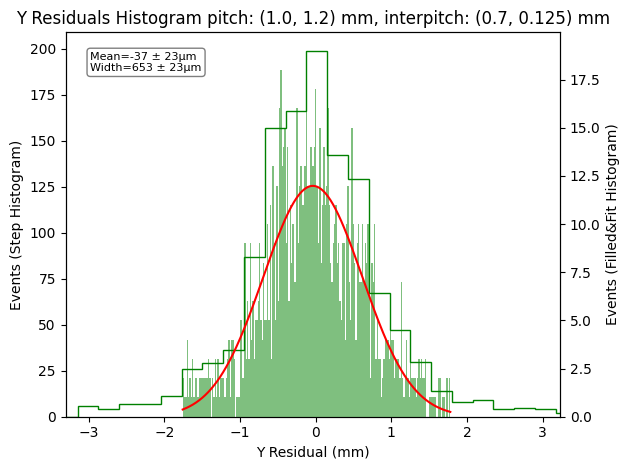

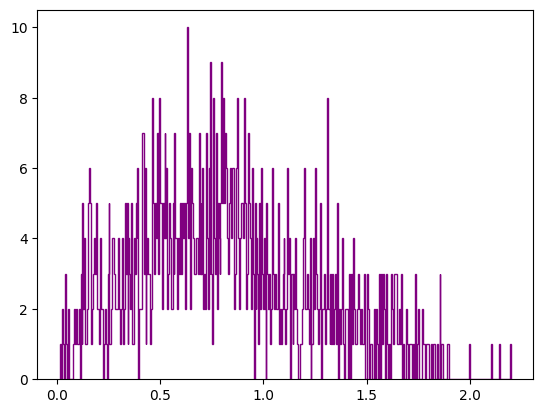

In [19]:
get_residuals(det, ray_data, plot=True, in_det=True, tolerance=0.2)

In [20]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2)

   pitch_x  pitch_y  interpitch_x  interpitch_y    x_mean  x_mean_err  \
0      1.0      1.2           0.7         0.125 -0.021143    0.016696   
1      1.0      1.2           0.7         0.125  0.022213    0.020353   
2      1.0      1.2           0.7         0.125 -0.030679    0.015027   
3      1.0      1.2           0.7         0.125  0.089644    0.020632   

     y_mean  y_mean_err     x_std  x_std_err     y_std  y_std_err  
0  0.687304    0.024113  0.525177   0.016711  0.687304   0.024113  
1  0.614062    0.020684  0.557851   0.020397  0.614062   0.020684  
2  0.714468    0.025048  0.577870   0.015045  0.714468   0.025048  
3  0.653443    0.022749  0.590374   0.020751  0.653443   0.022749  


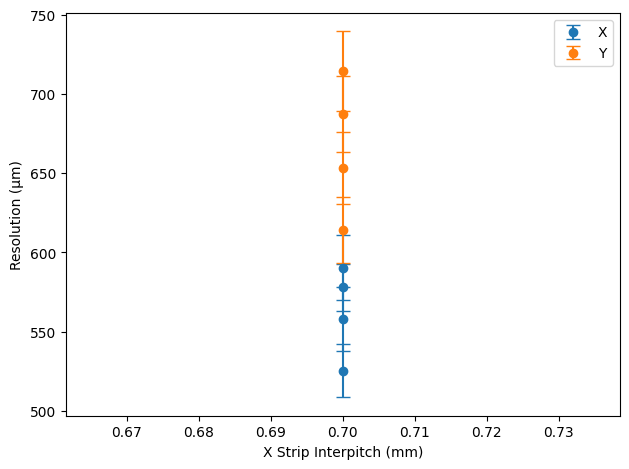

In [21]:
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['interpitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['interpitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

   pitch_x  pitch_y  interpitch_x  interpitch_y    x_mean  x_mean_err  \
0      1.0      1.2           0.7         0.125 -0.028774    0.017285   
1      1.0      1.2           0.7         0.125  0.020043    0.020750   
2      1.0      1.2           0.7         0.125 -0.033204    0.017114   
3      1.0      1.2           0.7         0.125  0.092961    0.024013   

     y_mean  y_mean_err     x_std  x_std_err     y_std  y_std_err  
0  0.633153    0.026577  0.480830   0.018223  0.633153   0.026577  
1  0.569718    0.027301  0.520182   0.022570  0.569718   0.027301  
2  0.651218    0.032096  0.527044   0.018388  0.651218   0.032096  
3  0.603027    0.028569  0.562163   0.027009  0.603027   0.028569  


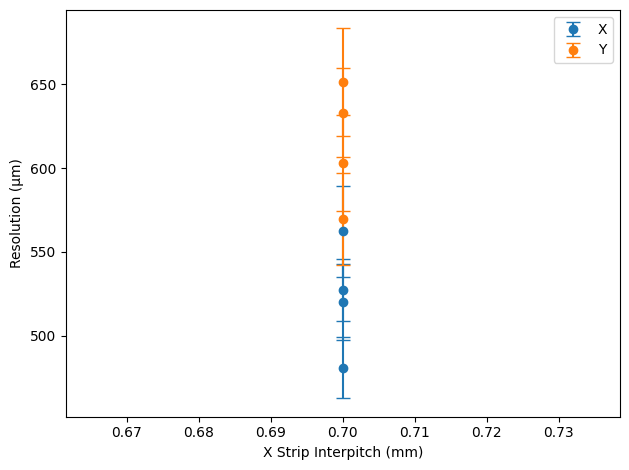

In [22]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2, max_r=2)
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['interpitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['interpitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

New stuff above

   pitch_x  pitch_y  interpitch_x  interpitch_y    x_mean  x_mean_err  \
0      1.0      1.2           0.7         0.125 -0.028774    0.017285   
1      1.0      1.2           0.7         0.125  0.020043    0.020750   
2      1.0      1.2           0.7         0.125 -0.033204    0.017114   
3      1.0      1.2           0.7         0.125  0.092961    0.024013   

     y_mean  y_mean_err     x_std  x_std_err     y_std  y_std_err  
0  0.633153    0.026577  0.480830   0.018223  0.633153   0.026577  
1  0.569718    0.027301  0.520182   0.022570  0.569718   0.027301  
2  0.651218    0.032096  0.527044   0.018388  0.651218   0.032096  
3  0.603027    0.028569  0.562163   0.027009  0.603027   0.028569  


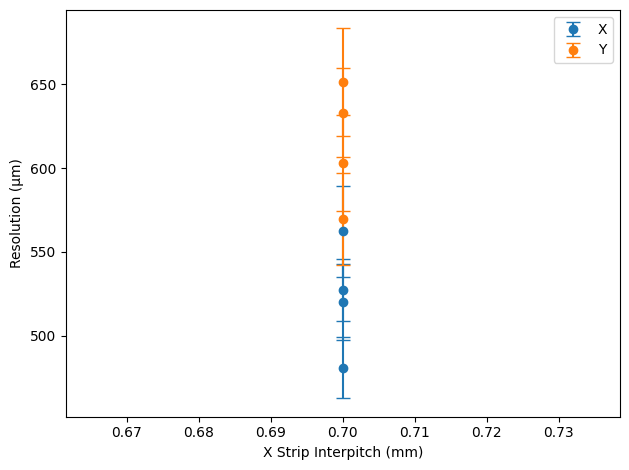

In [23]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2, max_r=2)
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['interpitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['interpitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

Rays in sub-detector 0: 2557, total rays: 62298
Rays in sub-detector 1: 1906, total rays: 62298
Rays in sub-detector 2: 2573, total rays: 62298
Rays in sub-detector 3: 1760, total rays: 62298


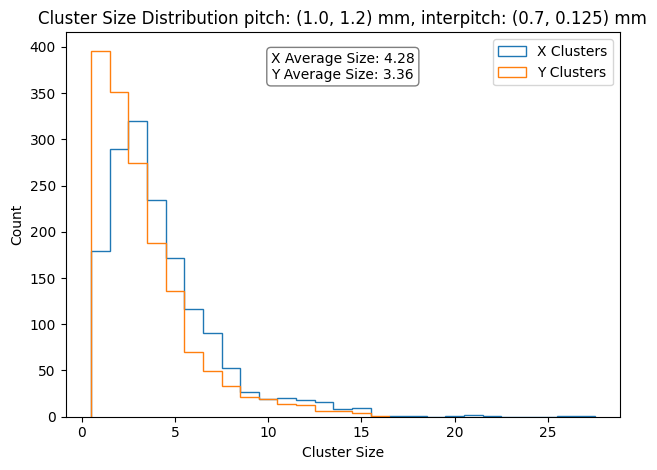

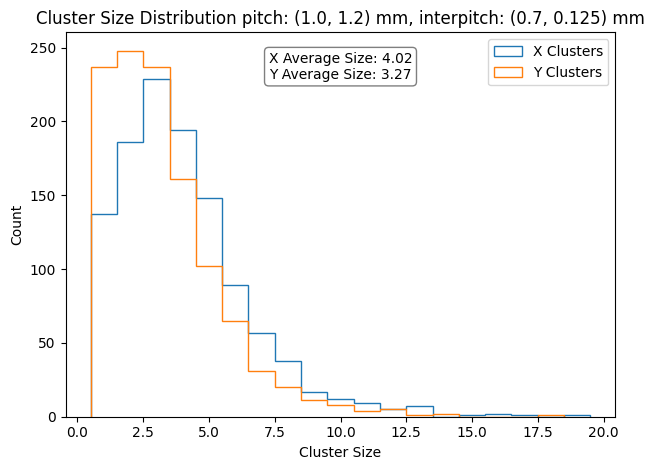

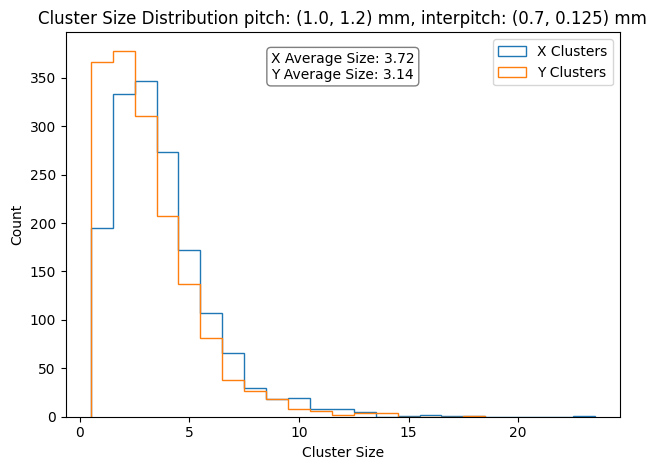

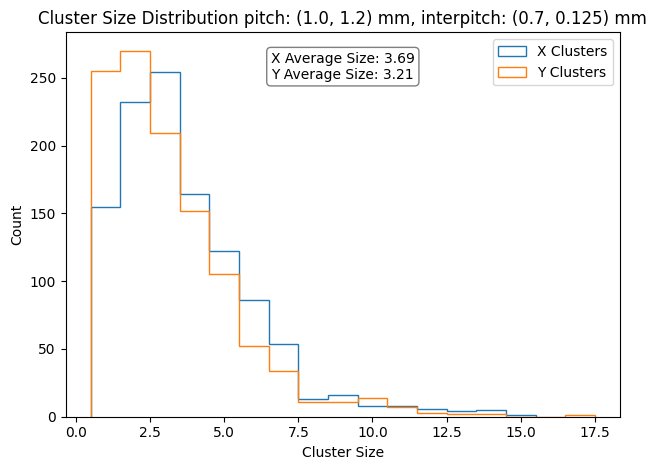

In [24]:
x_rays, y_rays, event_num_rays = ray_data.get_xy_positions(det.center[2])
pitches, x_means, x_errs, y_means, y_errs = [], [], [], [], []
for sub_det in det.sub_detectors:
    x_rays_in, y_rays_in, event_num_rays_in = get_rays_in_sub_det_vectorized(det, det.sub_detectors[sub_det.sub_index], x_rays, y_rays, event_num_rays, tolerance=-2)
    print(f'Rays in sub-detector {sub_det.sub_index}: {len(x_rays_in)}, total rays: {len(x_rays)}')
    x_mean, y_mean, x_err, y_err = sub_det.plot_cluster_sizes(event_nums=event_num_rays_in)
    pitches.append(sub_det.x_interpitch)
    x_means.append(x_mean)
    x_errs.append(x_err)
    y_means.append(y_mean)
    y_errs.append(y_err)

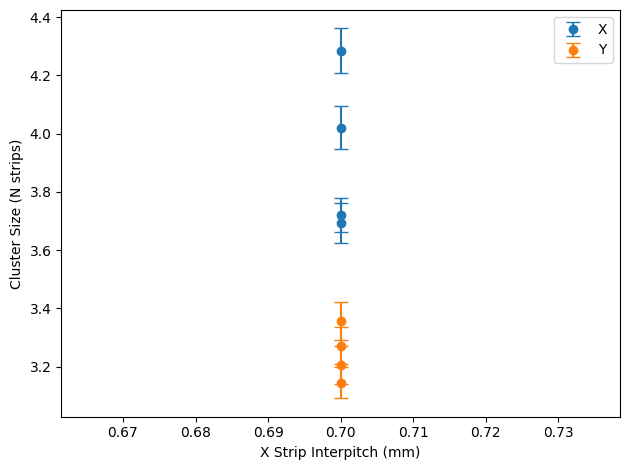

In [25]:
fig, ax = plt.subplots()
ax.errorbar(pitches, x_means, yerr=x_errs, fmt='o', capsize=5, label='X')
ax.errorbar(pitches, y_means, yerr=y_errs, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Cluster Size (N strips)')
fig.tight_layout()

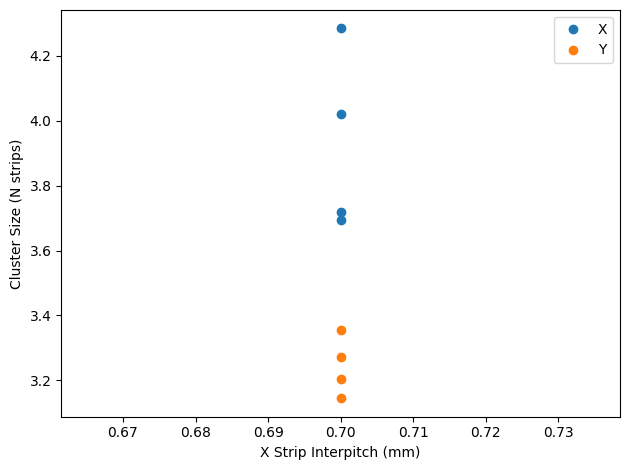

In [26]:
fig, ax = plt.subplots()
ax.plot(pitches, x_means, 'o', label='X')
ax.plot(pitches, y_means, 'o', label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Cluster Size (N strips)')
fig.tight_layout()

In [27]:
x_res, y_res, x_rays, y_rays = get_raw_residuals(det, ray_data, in_det=True, tolerance=0.0)

scan_res min: 232.47513935059638, max: 36052.450386569995
res_vmax: 958.8210231258089
mean_vmin: -214.89560769481008, mean_vmax: 240.8439696855328


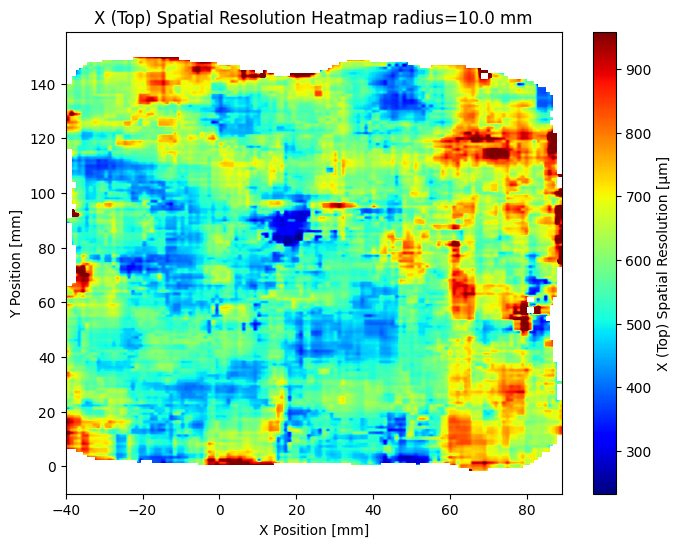

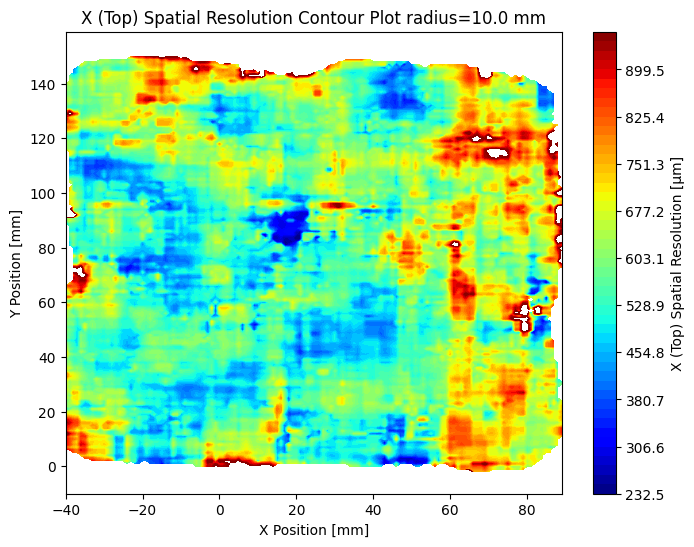

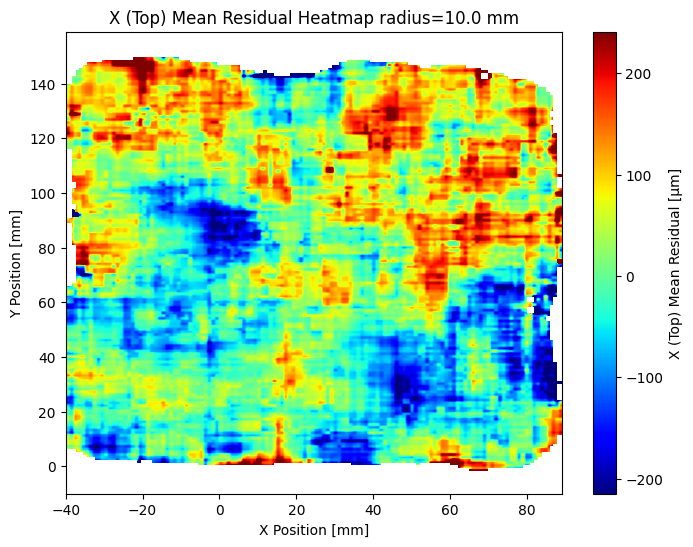

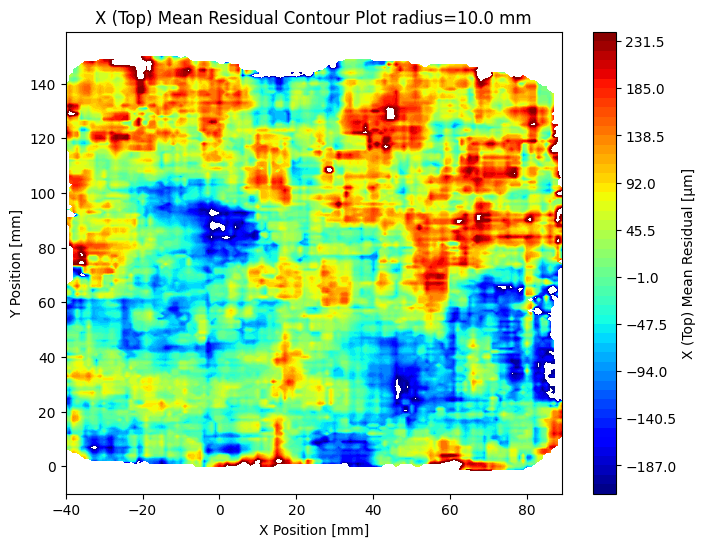

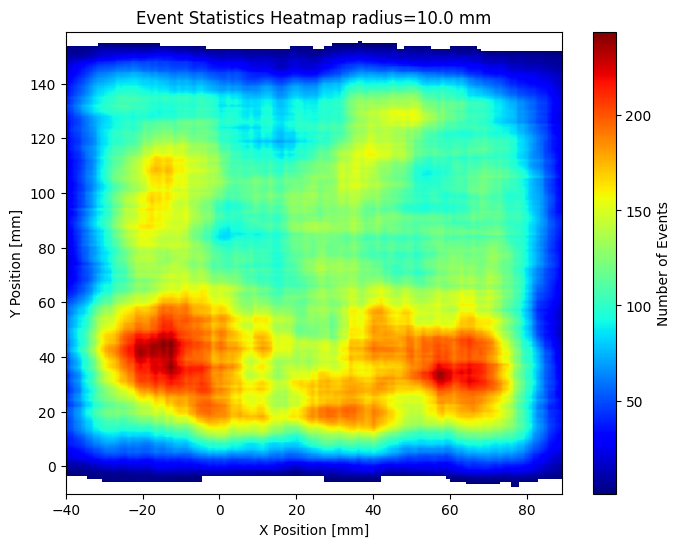

In [28]:
scan_xs = np.arange(-40, 90, 1.0)
scan_ys = np.arange(-10, 160, 1.0)

# Generate mesh grid
x_mesh, y_mesh = np.meshgrid(scan_xs, scan_ys)
xy_pairs = list(zip(x_mesh.ravel(), y_mesh.ravel()))  # Flatten to list of (x, y) pairs
scan_radius = 10  # mm
min_events = 30
# res_range = [160, 810]  # μm
# mean_range = [-200, 210]  # μm
res_range = None  # μm
mean_range = None  # μm

scan_resolutions_x, scan_means_x, events_x = get_circle_scan(np.array(x_res), np.array(x_rays), np.array(y_rays), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_resolutions_x, scan_means_x, scan_xs, scan_ys, scan_events=events_x, radius=scan_radius, percentile_filter=(1, 99), conversion_factor=1e3, unit_str='μm', res_title='X (Top) Spatial Resolution', mean_title='X (Top) Mean Residual', res_range=res_range, mean_range=mean_range)

scan_res min: 186.52477449387456, max: 116225.86826840573
res_vmax: 1138.8533266650527
mean_vmin: -274.92897093998386, mean_vmax: 319.8947064121993


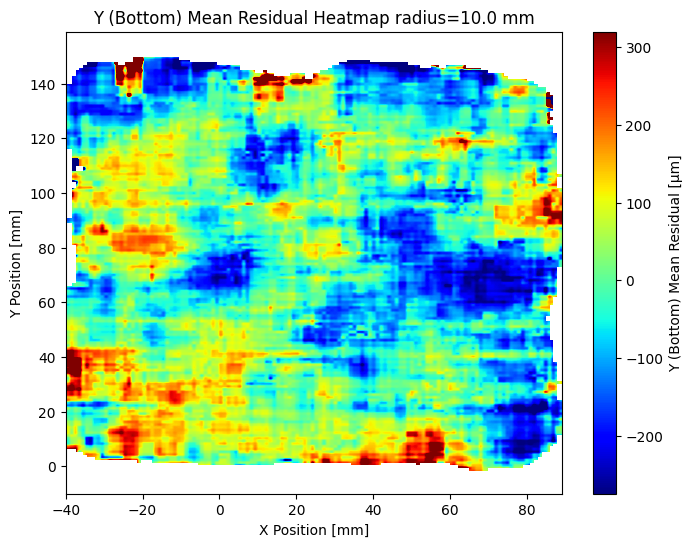

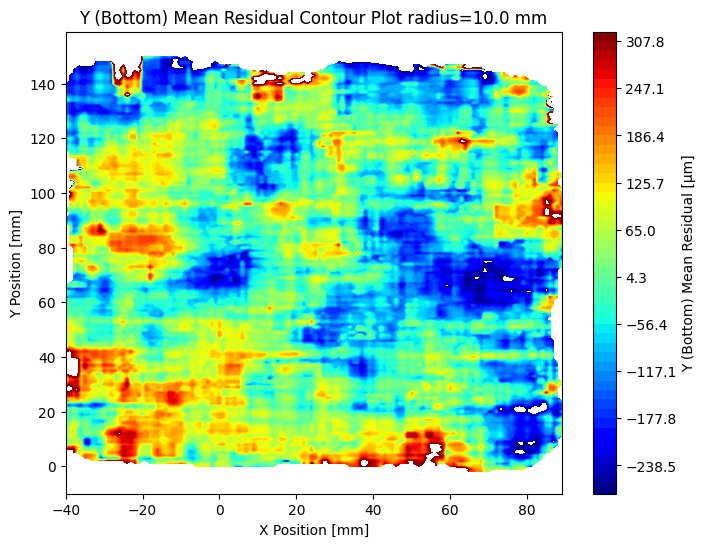

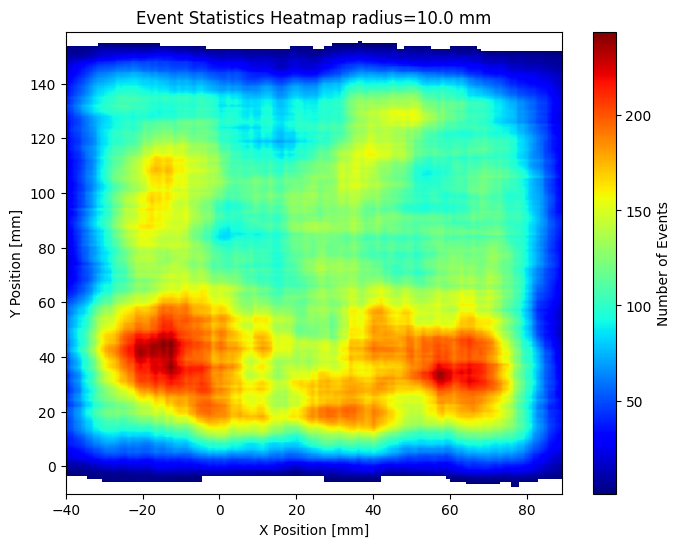

In [29]:
scan_resolutions_y, scan_means_y, events_y = get_circle_scan(np.array(y_res), np.array(x_rays), np.array(y_rays), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_resolutions_y, scan_means_y, scan_xs, scan_ys, scan_events=events_y, radius=scan_radius, percentile_filter=(1, 99), conversion_factor=1e3, unit_str='μm', res_title='Y (Bottom) Spatial Resolution', mean_title='Y (Bottom) Mean Residual', res_range=res_range, mean_range=mean_range)

In [30]:
x_res, y_res, x_rays, y_rays = get_raw_residuals(det, ray_data, in_det=True, tolerance=0.0)
scan_radius = 10
min_events = 20
x_rays, y_rays, event_num_rays = ray_data.get_xy_positions(det.center[2])
x_sizes_all, y_sizes_all, x_rays_cluster_sizes, y_rays_cluster_sizes = [], [], [], []
for sub_det in det.sub_detectors:
    x_rays_in, y_rays_in, event_num_rays_in = get_rays_in_sub_det_vectorized(det, det.sub_detectors[sub_det.sub_index], x_rays, y_rays, event_num_rays, tolerance=0)
    x_sizes, y_sizes, ray_mask = sub_det.get_cluster_sizes(largest=True, event_nums=event_num_rays_in, return_ray_mask=True)
    x_sizes_all.extend(x_sizes)
    y_sizes_all.extend(y_sizes)
    x_rays_cluster_sizes.extend(x_rays_in[ray_mask])
    y_rays_cluster_sizes.extend(y_rays_in[ray_mask])
scan_resolutions_csx, scan_means_csx, events_csx = get_circle_scan(np.array(x_sizes_all), np.array(x_rays_cluster_sizes), np.array(y_rays_cluster_sizes), xy_pairs, radius=scan_radius, shape='square', gaus_fit=False, min_events=min_events, plot=False)
plot_2D_circle_scan(scan_resolutions_csx, scan_means_csx, scan_xs, scan_ys, scan_events=events_csx, radius=scan_radius, percentile_filter=(1, 95), plot='mean', unit_str='N strips', mean_title='X Cluster Size')

scan_res min: 57.0, max: 1075.0
res_vmax: 779.5499999999993
mean_vmin: 3.423076923076923, mean_vmax: 4.571428571428571


scan_res min: 57.0, max: 755.0
res_vmax: 630.0
mean_vmin: 3.129032258064516, mean_vmax: 4.289827086456772


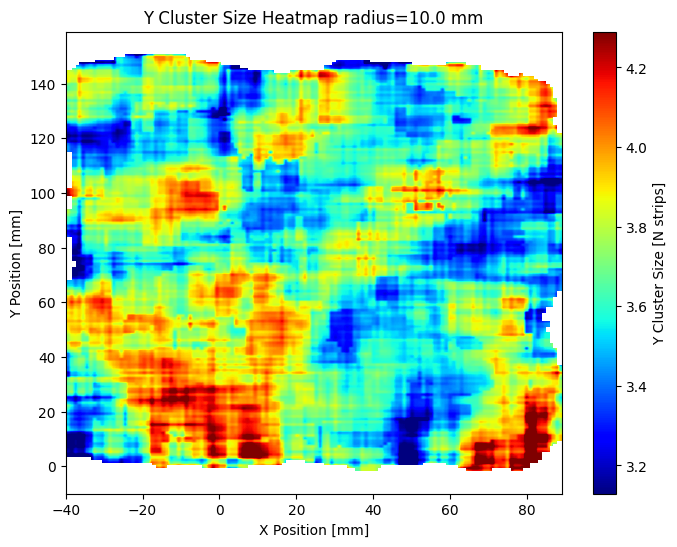

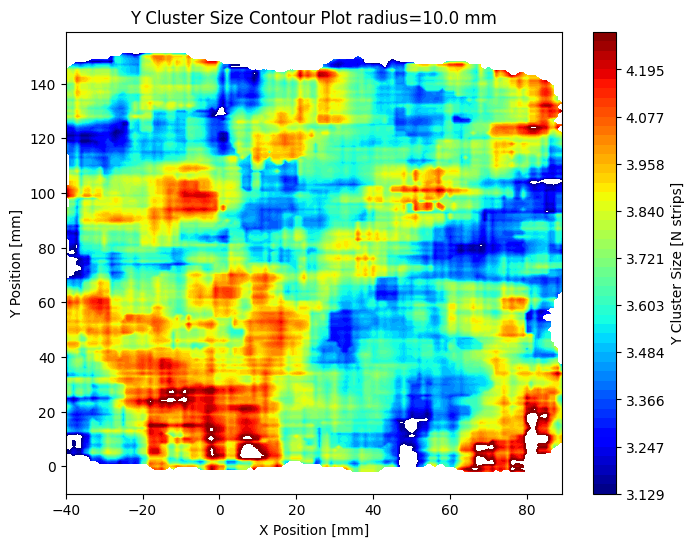

In [31]:
scan_resolutions_csy, scan_means_csy, events_csy = get_circle_scan(np.array(y_sizes_all), np.array(x_rays_cluster_sizes), np.array(y_rays_cluster_sizes), xy_pairs, radius=scan_radius, percentile_cuts=(1, 99), shape='square', gaus_fit=False, min_events=min_events, plot=False)
plot_2D_circle_scan(scan_resolutions_csy, scan_means_csy, scan_xs, scan_ys, scan_events=events_csy, radius=scan_radius, percentile_filter=(1, 99), plot='mean', unit_str='N strips', mean_title='Y Cluster Size')

Text(0.5, 1.0, 'Time of Max for Y (Bottom) Strips')

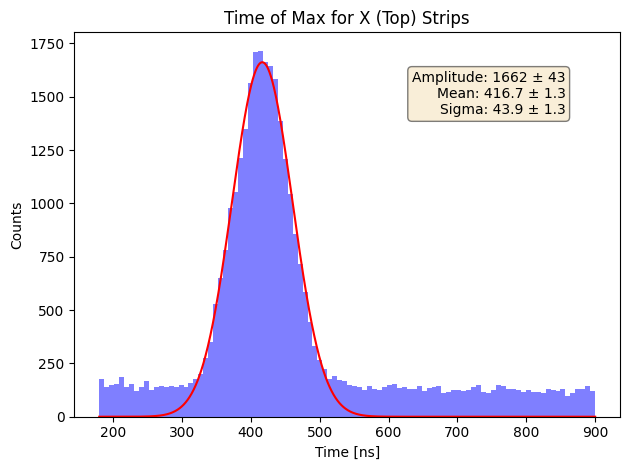

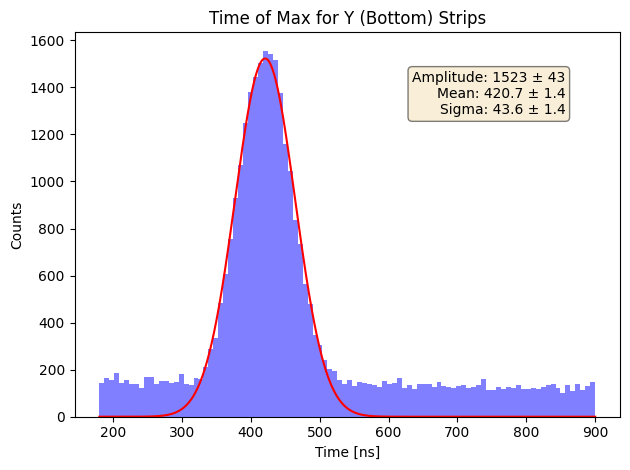

In [32]:
det.dream_data.correct_for_fine_timestamps()

sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=None, plot=True)
plt.title(f'Time of Max for X (Top) Strips')

sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=None, plot=True)
plt.title(f'Time of Max for Y (Bottom) Strips')

Text(0.5, 1.0, 'Time of Max for Y (Bottom) Strips Min Amp 600')

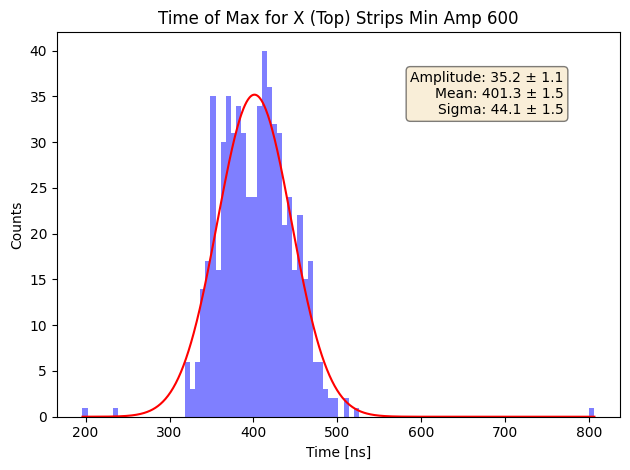

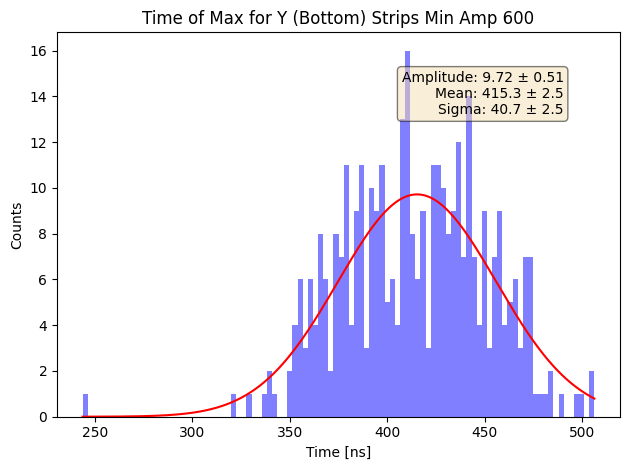

In [33]:
min_amp = 600
sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=min_amp, plot=True)
plt.title(f'Time of Max for X (Top) Strips Min Amp {min_amp}')

sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=min_amp, plot=True)
plt.title(f'Time of Max for Y (Bottom) Strips Min Amp {min_amp}')

Text(0.5, 0, 'Ray Y Angles')

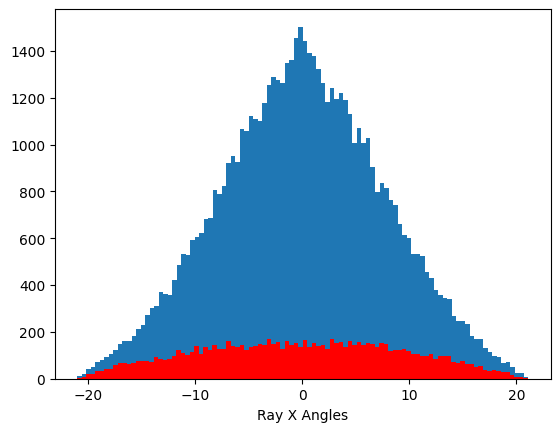

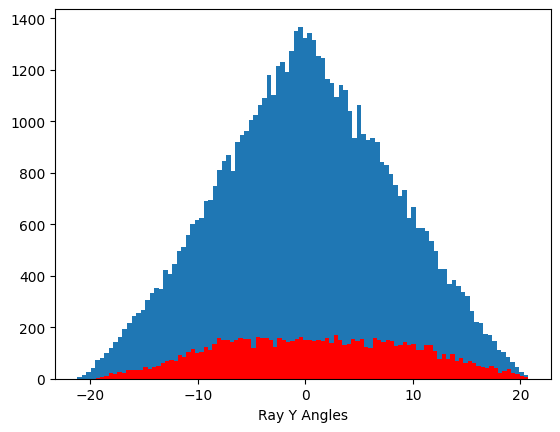

In [34]:
x_rays, y_rays, event_num_rays = ray_data.get_xy_positions(det.center[2])
x_ray_angles, y_ray_angles, event_num_rays = ray_data.get_xy_angles()

in_det_mask = det.in_det_mask(x_rays, y_rays, np.full_like(x_rays, det.center[2]))

fig_x_angles, ax_x_angles = plt.subplots()
ax_x_angles.hist(np.rad2deg(x_ray_angles), bins=100)
ax_x_angles.hist(np.rad2deg(x_ray_angles[in_det_mask]), color='r', bins=100)
ax_x_angles.set_xlabel('Ray X Angles')

fig_y_angles, ax_y_angles = plt.subplots()
ax_y_angles.hist(np.rad2deg(y_ray_angles), bins=100)
ax_y_angles.hist(np.rad2deg(y_ray_angles[in_det_mask]), color='r', bins=100)
ax_y_angles.set_xlabel('Ray Y Angles')

In [35]:
# min_amp = 0
# max_ray_angle = 8  # Degrees
# good_event_num_mask = np.isin(event_num_rays, det.dream_data.event_nums)
# x_rays_angles_filtered, y_ray_angles_filtered = x_ray_angles[good_event_num_mask], y_ray_angles[good_event_num_mask]
# ray_filter = (np.abs(x_rays_angles_filtered) < np.deg2rad(max_ray_angle)) & (np.abs(y_ray_angles_filtered) < np.deg2rad(max_ray_angle))
# sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=min_amp, event_filter=ray_filter, plot=True)
# plt.title(f'Time of Max for X (Top) Strips Min Amp {min_amp} & Max Ray Angle {max_ray_angle}°')
#
# sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=min_amp, event_filter=ray_filter, plot=True)
# plt.title(f'Time of Max for Y (Bottom) Strips Min Amp {min_amp} & Max Ray Angle {max_ray_angle}°')

In [36]:
# min_amp = 350
# angles = np.arange(2, 20, 1)  # example: 2, 4, 6, 8 degrees
#
# sigma_x_vals, sigma_x_errs = [], []
# sigma_y_vals, sigma_y_errs = [], []
#
# for max_ray_angle in angles:
#     good_event_num_mask = np.isin(event_num_rays, det.dream_data.event_nums)
#     x_rays_angles_filtered = x_ray_angles[good_event_num_mask]
#     y_rays_angles_filtered = y_ray_angles[good_event_num_mask]
#
#     ray_filter = (
#         (np.abs(x_rays_angles_filtered) < np.deg2rad(max_ray_angle)) &
#         (np.abs(y_rays_angles_filtered) < np.deg2rad(max_ray_angle))
#     )
#
#     # --- X strips ---
#     sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(
#         max_channel=True,
#         channels=np.arange(0, int(256 / 2)),
#         min_amp=min_amp,
#         event_filter=ray_filter,
#         plot=False
#     )
#
#     sigma_x_vals.append(sigma_x)
#     sigma_x_errs.append(sigma_x_err)
#
#     # --- Y strips ---
#     sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(
#         max_channel=True,
#         channels=np.arange(int(256 / 2), 256),
#         min_amp=min_amp,
#         event_filter=ray_filter,
#         plot=False
#     )
#
#     sigma_y_vals.append(sigma_y)
#     sigma_y_errs.append(sigma_y_err)
#
# # --- summary plot ---
# plt.figure()
# plt.errorbar(angles, sigma_x_vals, yerr=sigma_x_errs, fmt='o-', label="X strips")
# plt.errorbar(angles, sigma_y_vals, yerr=sigma_y_errs, fmt='s-', label="Y strips")
# plt.xlabel("Max Ray Angle (degrees)")
# plt.ylabel("σ (Time of Max)")
# plt.title("σ vs Max Ray Angle")
# plt.legend()
# plt.show()


In [37]:
x_time_maxes = det.dream_data.get_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=None, filter_times=False)
x_time_maxes, x_time_filter = det.dream_data.filter_time_maxes(x_time_maxes, return_mask=True)
y_time_maxes = det.dream_data.get_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=None, filter_times=False)
y_time_maxes, y_time_filter = det.dream_data.filter_time_maxes(y_time_maxes, return_mask=True)
time_ray_event_mask_x = np.isin(event_num_rays, det.dream_data.event_nums[x_time_filter])
time_ray_event_mask_y = np.isin(event_num_rays, det.dream_data.event_nums[y_time_filter])
x_rays_timing_x, y_rays_timing_x = x_rays[time_ray_event_mask_x], y_rays[time_ray_event_mask_x]
x_rays_timing_y, y_rays_timing_y = x_rays[time_ray_event_mask_y], y_rays[time_ray_event_mask_y]

In [38]:
scan_radius = 10
min_events = 30
res_range = [20, 44]  # ns
mean_range = [405, 425]  # ns
scan_time_resolutions_x, scan_time_means_x, events_time_x = get_circle_scan(np.array(x_time_maxes), np.array(x_rays_timing_x), np.array(y_rays_timing_x), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_time_resolutions_x, scan_time_means_x, scan_xs, scan_ys, scan_events=events_time_x, radius=scan_radius, percentile_filter=(1, 99), plot='both', unit_str='ns', res_title='Time Resolution X (Top) Strips', mean_title='Mean Time X (Top) Strips', res_range=res_range, mean_range=mean_range)

IndexError: boolean index did not match indexed array along axis 0; size of axis is 34498 but size of corresponding boolean axis is 10548

In [ ]:
scan_time_resolutions_y, scan_time_means_y, events_time_y = get_circle_scan(np.array(y_time_maxes), np.array(x_rays_timing_y), np.array(y_rays_timing_y), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_time_resolutions_y, scan_time_means_y, scan_xs, scan_ys, scan_events=events_time_y, radius=scan_radius, percentile_filter=(1, 99), plot='both', unit_str='ns', res_title='Time Resolution Y (Bottom) Strips', mean_title='Mean Time Y (Bottom) Strips', res_range=res_range, mean_range=mean_range)

In [40]:
channel_nums = np.arange(27, 127, 1)
min_amp = 600
time_resolutions_x, time_resolutions_errs_x = [], []
for channel_num in channel_nums:
    sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=[channel_num], min_amp=min_amp, plot=False)
    time_resolutions_x.append(sigma_x)
    time_resolutions_errs_x.append(sigma_x_err)
fig, ax = plt.subplots()
ax.errorbar(channel_nums, np.array(time_resolutions_x), yerr=np.array(time_resolutions_errs_x), fmt='o', capsize=5)
ax.set_xlabel('Channel Number')
ax.set_ylabel('Time Resolution (ns)')
ax.set_title(f'Time Resolution for X (Top) Strips, Min Amp {min_amp}')
fig.tight_layout()

Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.


/local/home/dn277127/PycharmProjects/saclay_micromegas/Detector_Classes/DreamData.py:1399: RuntimeWarning: divide by zero encountered in divide
  return a * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))
/local/home/dn277127/PycharmProjects/saclay_micromegas/Detector_Classes/DreamData.py:660: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = cf(gaussian, bin_centers, hist, p0=p0)


ZeroDivisionError: division by zero

In [41]:
channel_nums = np.arange(155, 256, 1)
min_amp, max_amp = 600, 3500
time_resolutions_y, time_resolutions_errs_y = [], []
for channel_num in channel_nums:
    sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=[channel_num], min_amp=min_amp, plot=False)
    time_resolutions_y.append(sigma_y)
    time_resolutions_errs_y.append(sigma_y_err)
fig, ax = plt.subplots()
ax.errorbar(channel_nums, np.array(time_resolutions_y), yerr=np.array(time_resolutions_errs_y), fmt='o', capsize=5)
ax.set_xlabel('Channel Number')
ax.set_ylabel('Time Resolution (ns)')
ax.set_title(f'Time Resolution for Y (Bottom) Strips, Min Amp {min_amp}')
fig.tight_layout()

/local/home/dn277127/PycharmProjects/saclay_micromegas/Detector_Classes/DreamData.py:1399: RuntimeWarning: divide by zero encountered in divide
  return a * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))
/local/home/dn277127/PycharmProjects/saclay_micromegas/Detector_Classes/DreamData.py:660: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = cf(gaussian, bin_centers, hist, p0=p0)


Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.


ZeroDivisionError: division by zero

Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.


/local/home/dn277127/PycharmProjects/saclay_micromegas/Detector_Classes/DreamData.py:1399: RuntimeWarning: divide by zero encountered in divide
  return a * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))
/local/home/dn277127/PycharmProjects/saclay_micromegas/Detector_Classes/DreamData.py:660: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = cf(gaussian, bin_centers, hist, p0=p0)


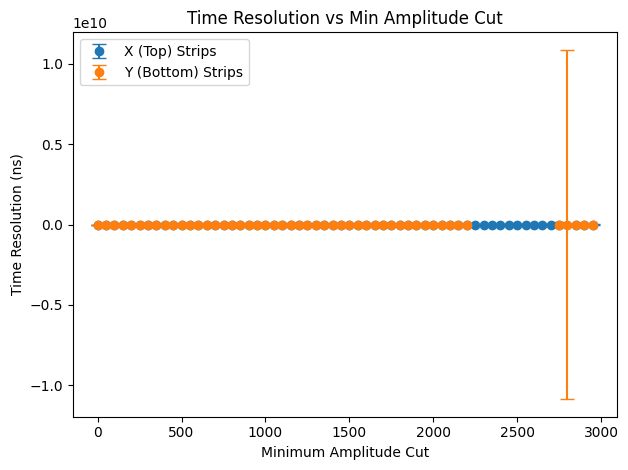

In [42]:
min_amps = np.arange(0, 3000, 50)
time_resolutions_x, time_resolutions_errs_x = [], []
time_resolutions_y, time_resolutions_errs_y = [], []
for min_amp_i in min_amps:
    sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, 128), min_amp=min_amp_i, max_amp=3500, plot=False)
    time_resolutions_x.append(sigma_x)
    time_resolutions_errs_x.append(sigma_x_err)
    sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(129, 256), min_amp=min_amp_i, max_amp=3500, plot=False)
    time_resolutions_y.append(sigma_y)
    time_resolutions_errs_y.append(sigma_y_err)
fig, ax = plt.subplots()
ax.errorbar(min_amps, np.array(time_resolutions_x), yerr=np.array(time_resolutions_errs_x), fmt='o', capsize=5, label='X (Top) Strips')
ax.errorbar(min_amps, np.array(time_resolutions_y), yerr=np.array(time_resolutions_errs_y), fmt='o', capsize=5, label='Y (Bottom) Strips')
ax.set_xlabel('Minimum Amplitude Cut')
ax.set_ylabel('Time Resolution (ns)')
ax.set_title(f'Time Resolution vs Min Amplitude Cut')
ax.legend()
fig.tight_layout()

In [43]:
min_amps = np.arange(0, 2600, 50)
amp_range = 50
time_resolutions_x, time_resolutions_errs_x = [], []
time_resolutions_y, time_resolutions_errs_y = [], []
for min_amp_i in min_amps:
    sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, 128), min_amp=min_amp_i, max_amp=min_amp_i + amp_range, plot=False)
    time_resolutions_x.append(sigma_x)
    time_resolutions_errs_x.append(sigma_x_err)
    sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(129, 256), min_amp=min_amp_i, max_amp=min_amp_i + amp_range, plot=False)
    time_resolutions_y.append(sigma_y)
    time_resolutions_errs_y.append(sigma_y_err)
fig, ax = plt.subplots()
mid_amps = min_amps + amp_range / 2
ax.errorbar(mid_amps, np.array(time_resolutions_x), yerr=np.array(time_resolutions_errs_x), fmt='o', capsize=5, label='X (Top) Strips')
ax.errorbar(mid_amps, np.array(time_resolutions_y), yerr=np.array(time_resolutions_errs_y), fmt='o', capsize=5, label='Y (Bottom) Strips')
ax.set_xlabel('Minimum Amplitude Cut')
ax.set_ylabel('Time Resolution (ns)')
ax.set_title(f'Time Resolution vs Amplitude ({amp_range}ns window)')
ax.legend()
fig.tight_layout()

Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.
Error: Gaussian fit failed.


ZeroDivisionError: division by zero

In [ ]:
edge_cushion = 5 # mm
det_z = det.center[2]
for sub_det in det.sub_detectors:
    x_min_loc, x_max_loc = np.min(sub_det.x_pos), np.max(sub_det.x_pos)
    y_min_loc, y_max_loc = np.min(sub_det.y_pos), np.max(sub_det.y_pos)
    top_left, top_right = (x_min_loc, y_max_loc, det_z), (x_max_loc, y_max_loc, det_z)
    bottom_left, bottom_right = (x_min_loc, y_min_loc, det_z), (x_max_loc, y_min_loc, det_z)
    top_left, top_right = det.convert_coords_to_global(top_left), det.convert_coords_to_global(top_right)
    bottom_left, bottom_right = det.convert_coords_to_global(bottom_left), det.convert_coords_to_global(bottom_right)
    print(f'Sub-detector {sub_det.sub_index} corners:')
    print(f'Top Left: {top_left}, Top Right: {top_right}, Bottom Left: {bottom_left}, Bottom Right: {bottom_right}')
